In [1]:
import pandas as pd
import finterstellar as fs

In [2]:
path = './data/'
cd = ['CSI 300', 'KOSPI 200']

시세 읽어오기

In [3]:
file_name = path + cd[0] + ' Historical Data.csv'
df1 = pd.read_csv(file_name, index_col='Date')

# 날짜 처리
ld = fs.LoadData()
df1 = ld.date_formatting(df1)    
# date_formatting(데이터프레임) - 날짜 처리

df1 = ld.price_df_trimming(df1, cd[0])
# price_df_trimming(데이터프레임) - 시세 처리
df1.head()

,CSI 300
Date,
2017-01-03,3342.23
2017-01-04,3368.31
2017-01-05,3367.79
2017-01-06,3347.67
2017-01-09,3363.90


In [4]:
file_name = path + cd[1] + ' Historical Data.csv'
df2 = pd.read_csv(file_name, index_col='Date')

# 날짜 처리
ld = fs.LoadData()
df2 = ld.date_formatting(df2)    
# date_formatting(데이터프레임) - 날짜 처리

df2 = ld.price_df_trimming(df2, cd[1])
# price_df_trimming(데이터프레임) - 시세 처리
df2.head()

,KOSPI 200
Date,
2017-01-02,260.36
2017-01-03,262.97
2017-01-04,263.12
2017-01-05,261.98
2017-01-06,263.20


In [5]:
df = pd.concat([df1, df2], axis=1)    
# pd.concat([데이터프레임1, 데이터프레임2, ...], axis=1) - 데이터프레임 합치기
df.tail()

,CSI 300,KOSPI 200
Date,,
2019-04-22,4025.61,285.87
2019-04-23,4019.01,286.47
2019-04-24,4030.09,283.70
2019-04-25,3941.82,282.83
2019-04-26,3889.27,281.34


구멍 메우기 (보간법)

In [6]:
df = df.fillna(method='ffill')
# df.fillna(method='ffill') - 앞의 데이터로 뒤 구멍 메우기
df.tail()

,CSI 300,KOSPI 200
Date,,
2019-04-22,4025.61,285.87
2019-04-23,4019.01,286.47
2019-04-24,4030.09,283.70
2019-04-25,3941.82,282.83
2019-04-26,3889.27,281.34


기준일 설정

In [7]:
df.loc['2018-01-02']

CSI 300      4087.4
KOSPI 200     326.0
Name: 2018-01-02 00:00:00, dtype: float64

In [9]:
base_date = '2018-01-02'    # 기준일자 설정

기준일 이후로 샘플데이터 만들기

In [10]:
sample = df.loc[base_date:].copy()    # 기준일 이후 데이터만 가져와 sample에 저장 (샘플링)
sample.head()

,CSI 300,KOSPI 200
Date,,
2018-01-02,4087.40,326.00
2018-01-03,4111.39,327.13
2018-01-04,4128.81,324.58
2018-01-05,4138.75,328.97
2018-01-08,4160.16,331.28


회귀분석 finterstellar 이용

In [11]:
trd = fs.PairTrade()

In [12]:
regr = trd.regression(sample, cd)
regr

{'Slope': 0.042021489297799614,
 'Intercept': 144.0030153752973,
 'R2': 0.6154638150418552}

추세선을 이용해 x 주가를 이용해 y 주가를 계산

In [13]:
sample[cd[1]+' expected'] = sample[cd[0]] * regr['Slope'] + regr['Intercept']
# y주가 기대값은 추세선 상에 위치
sample[cd[1]+' spread'] = sample[cd[1]] - sample[cd[1]+' expected']
# 스프레드 = y주가 - 기대값
sample.head()

,CSI 300,KOSPI 200,KOSPI 200 expected,KOSPI 200 spread
Date,,,,
2018-01-02,4087.40,326.00,315.761651,10.238349
2018-01-03,4111.39,327.13,316.769746,10.360254
2018-01-04,4128.81,324.58,317.501761,7.078239
2018-01-05,4138.75,328.97,317.919454,11.050546
2018-01-08,4160.16,331.28,318.819134,12.460866


역치값 설정

In [14]:
# trading strategy determinants
threshold = 0.02   # percent 값으로 오차허용 구간을 정의

트레이딩북 생성

In [15]:
book = pd.DataFrame()    # 빈 트레이딩북(데이터프레임) 생성
book[cd] = sample[cd]    # sample에서 시세 복사
book['trade'] = ''    # 매매전략 입력을 위한 trade 컬럼 생성
for c in cd:    # 종목쌍 내의 각 종목에 대해
    book['p '+c] = ''     # 포지션 입력을 위한 p 종목코드 컬럼 생성

In [16]:
book.head()

,CSI 300,KOSPI 200,trade,p CSI 300,p KOSPI 200
Date,,,,,
2018-01-02,4087.40,326.00,,,
2018-01-03,4111.39,327.13,,,
2018-01-04,4128.81,324.58,,,
2018-01-05,4138.75,328.97,,,
2018-01-08,4160.16,331.28,,,


일별 매매내역

In [17]:
for i in sample.index:
    thd = float( threshold * sample.loc[i, cd[1]] )    # 오차구간 계산
    if sample.loc[i, cd[1]+' spread'] > thd:     # if 스프레드 > 오차구간 :
        book.loc[i, 'trade'] = 'buy '+cd[0]      # trade : buy 종목X
    elif threshold >= sample.loc[i, cd[1]+' spread'] and sample.loc[i, cd[1]+' spread'] >= 0:    
    # elif 오차구간 >= 스프레드 & 스프레드 >= 0 :
        book.loc[i, 'trade'] = ''     # trade : clear
    elif 0 > sample.loc[i, cd[1]+' spread'] and sample.loc[i, cd[1]+' spread'] >= -thd:
    # elif 0 >= 스프레드 & 스프레드 >= -오차구간 :
        book.loc[i, 'trade'] = ''     # trade : clear
    elif -threshold > sample.loc[i, cd[1]+' spread']:
    # elif -오차구간 > 스프레드 :
        book.loc[i, 'trade'] = 'buy '+cd[1]     # trade : buy 종목Y

In [18]:
book.head()

,CSI 300,KOSPI 200,trade,p CSI 300,p KOSPI 200
Date,,,,,
2018-01-02,4087.40,326.00,buy CSI 300,,
2018-01-03,4111.39,327.13,buy CSI 300,,
2018-01-04,4128.81,324.58,buy CSI 300,,
2018-01-05,4138.75,328.97,buy CSI 300,,
2018-01-08,4160.16,331.28,buy CSI 300,,


포지션 기록

In [19]:
for c in cd:
    status = ''
    for i in book.index:
        if book.loc[i, 'trade'] == 'buy '+c:     # 현재 buy 일때,
            if book.shift(1).loc[i, 'trade'] == 'buy '+c:   # 전일도 buy 였으면
                status = 'll'     # 롱>롱
            elif book.shift(1).loc[i, 'trade'] == '':    # 전일에 zero 였으면
                status = 'zl'     # zero>롱
            elif book.shift(1).loc[i, 'trade'] == 'sell '+c:    # 전일에 sell 였으면
                status = 'sl'     # 숏>롱
            else:    # 그밖의 경우
                status = 'zl'    # zero>롱
        elif book.loc[i, 'trade'] == 'sell '+c:
            if book.shift(1).loc[i, 'trade'] == 'buy '+c:
                status = 'ls'
            elif book.shift(1).loc[i, 'trade'] == '':
                status = 'zs'
            elif book.shift(1).loc[i, 'trade'] == 'sell '+c:
                status = 'ss'
            else:
                status = 'zs'
        elif book.loc[i, 'trade'] == '':
            if book.shift(1).loc[i, 'trade'] == 'buy '+c:
                status = 'lz'
            elif book.shift(1).loc[i, 'trade'] == '':
                status = 'zz'
            elif book.shift(1).loc[i, 'trade'] == 'sell '+c:
                status = 'sz'
            else:
                status = 'zz'
        else:
            status = 'zz'
        book.loc[i, 'p '+c] = status


In [20]:
book.head()

,CSI 300,KOSPI 200,trade,p CSI 300,p KOSPI 200
Date,,,,,
2018-01-02,4087.40,326.00,buy CSI 300,zl,zz
2018-01-03,4111.39,327.13,buy CSI 300,ll,zz
2018-01-04,4128.81,324.58,buy CSI 300,ll,zz
2018-01-05,4138.75,328.97,buy CSI 300,ll,zz
2018-01-08,4160.16,331.28,buy CSI 300,ll,zz


수익률 계산

In [21]:
rtn = 1.0
book['return'] = 1
for c in cd:     # 종목별로 순환
    buy = 0.0
    sell = 0.0
    for i in book.index:     # 일자별로 순환

        if book.loc[i, 'p '+c] == 'zl' or book.loc[i, 'p '+c] == 'sl' :     # long 진입
            buy = book.loc[i, c]    # 매수 가격 확정
            print(i.date(), 'long '+c, buy)
        elif book.loc[i, 'p '+c] == 'lz' or book.loc[i, 'p '+c] == 'ls' :     # long 청산
            sell = book.loc[i, c]    # 매도 가격 확정
            # 손익 계산
            rtn = (sell - buy) / buy + 1    
            # 손익 = (매도가-매수가)/매수가 + 1 , 100원 투자해서 10원 벌면 손익은 1.10
            book.loc[i, 'return'] = rtn    # 트레이딩북에 손익 기록
            print(i.date(), 'long '+c, buy, ' | unwind long '+c, sell, ' | return:', round(rtn, 4))

        elif book.loc[i, 'p '+c] == 'zs' or book.loc[i, 'p '+c] == 'ls' :     # short 진입
            sell = book.loc[i, c]    # 공매도 가격 확정
            print(i.date(), 'short '+c, sell)
        elif book.loc[i, 'p '+c] == 'sz' or book.loc[i, 'p '+c] == 'sl' :     # short 청산
            buy = book.loc[i, c]    # 숏커버 가격 확정
            # 손익 계산
            rtn = (sell - buy) / sell + 1
            book.loc[i, 'return'] = rtn
            print(i.date(), 'short '+c, sell, ' | unwind short '+c, buy, ' | return:', round(rtn, 4))

    if book.loc[i, 'trade'] == '' and book.loc[i, 'p '+c] == '':     # zero position
        buy = 0.0
        sell = 0.0

acc_rtn = 1.0
for i in book.index:
    rtn = book.loc[i, 'return']
    acc_rtn = acc_rtn * rtn
    book.loc[i, 'acc return'] = acc_rtn

print ('Accunulated return :', round(acc_rtn, 4))

2018-01-02 long CSI 300 4087.4
2018-01-11 long CSI 300 4087.4  | unwind long CSI 300 4205.59  | return: 1.0289
2018-01-16 long CSI 300 4258.47
2018-01-18 long CSI 300 4258.47  | unwind long CSI 300 4271.42  | return: 1.003
2018-01-26 long CSI 300 4381.3
2018-02-02 long CSI 300 4381.3  | unwind long CSI 300 4271.23  | return: 0.9749
2018-03-13 long CSI 300 4091.25
2018-03-19 long CSI 300 4091.25  | unwind long CSI 300 4074.25  | return: 0.9958
2018-03-20 long CSI 300 4077.7
2018-03-23 long CSI 300 4077.7  | unwind long CSI 300 3904.94  | return: 0.9576
2018-03-26 long CSI 300 3879.89
2018-03-29 long CSI 300 3879.89  | unwind long CSI 300 3894.05  | return: 1.0036
2018-03-30 long CSI 300 3898.5
2018-04-04 long CSI 300 3898.5  | unwind long CSI 300 3854.86  | return: 0.9888
2018-04-05 long CSI 300 3854.86
2018-04-06 long CSI 300 3854.86  | unwind long CSI 300 3854.86  | return: 1.0
2018-04-09 long CSI 300 3852.93
2018-04-10 long CSI 300 3852.93  | unwind long CSI 300 3927.17  | return: 1.

벤치마크 수익률

In [22]:
n = len(cd)    # 몇 종목인지?
rtn = dict()    # 각 종목의 수익률을 담을 딕셔너리 선언
bm_rtn = float()    # 벤치마크 수익률을 담을 변수 선언
for c in cd:    # 종목마다 돌면서
    rtn[c] = round (( book[c].iloc[-1] - book[c].iloc[0] ) / book[c].iloc[0] + 1, 4)   
    # 종목별 벤치마크 수익률 = (최종가격 - 최초가격) / 최초가격
    bm_rtn += rtn[c]/n   # 각 종목 수익률을 종목 개수로 나누고 합쳐준다
print('BM return:', round(bm_rtn, 4) )
print(rtn)

BM return: 0.9072
{'CSI 300': 0.9515, 'KOSPI 200': 0.863}


초과수익률 %

In [23]:
exs_rtn = ( round(acc_rtn/bm_rtn, 4) - 1 ) * 100
print('Excess return:', round(exs_rtn, 4) )

Excess return: 4.0


그래프 모듈 호출

In [24]:
import finterstellar as fs
v = fs.Visualize()     # fs 라이브러리의 Visualize() 모듈을 불러와 v로 지정

()

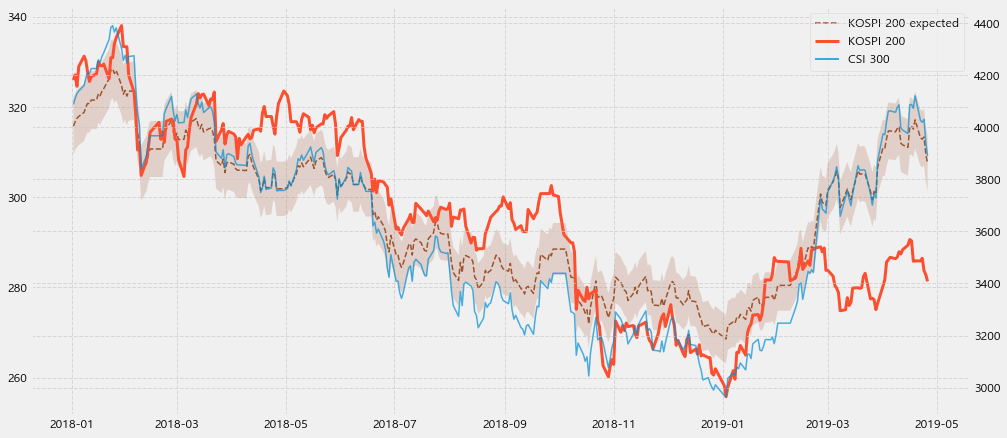

In [25]:
v.pair_trend_index_view(sample, threshold, cd)
# pairs_trend_index_view(데이터프레임, 역치, [종목코드쌍], (사이즈)) - 페어트레이딩 그래프 그리기

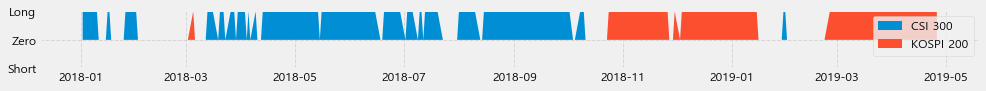

In [26]:
v.position_view(book, cd)
# v 모듈의 position_view(트레이딩북, 종목코드, (사이즈)) 함수를 이용해 포지션 보유내역 그래프 그리기